In [1]:
from IPython.display import Javascript
Javascript('IPython.notebook.execute_cells_below()')

<IPython.core.display.Javascript object>

## Data preprocessing

In [1]:
import glob
import os
import librosa
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
from matplotlib.pyplot import specgram
from sklearn.model_selection import train_test_split
from sklearn import preprocessing
from ipyparallel import Client

/home/c25yuan/.local/lib/python3.5/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [2]:
base_dir = "audio-cats-and-dogs/"
path = os.listdir(base_dir+"cats_dogs")
y = np.array([0 if 'cat' in f else 1 for f in path])  # change y to int values
#X_train, X_test, y_train, y_test = train_test_split(X_path, y, test_size=0.33)

In [3]:
## Ignoring this block
#train_test_split = pd.read_csv(base_dir+"train_test_split.csv")
#train = np.append(np.array((train_test_split["train_cat"].dropna())), np.array(train_test_split["train_dog"].dropna()))
#test = np.append(np.array((train_test_split["test_cat"].dropna())), np.array(train_test_split["test_dog"].dropna()))
#y_train = np.array([0 if 'cat' in f else 1 for f in train])
#y_test = np.array([0 if 'cat' in f else 1 for f in test])

In [4]:
# http://aqibsaeed.github.io/2016-09-03-urban-sound-classification-part-1/
def extract_feature(file_name):
    base_dir = "audio-cats-and-dogs/"
    import librosa
    import numpy as np
    X, sample_rate = librosa.load(base_dir+"cats_dogs/"+file_name)
    stft = np.abs(librosa.stft(X))
    mfccs = np.mean(librosa.feature.mfcc(y=X, sr=sample_rate, n_mfcc=40).T,axis=0)
    chroma = np.mean(librosa.feature.chroma_stft(S=stft, sr=sample_rate).T,axis=0)
    mel = np.mean(librosa.feature.melspectrogram(X, sr=sample_rate).T,axis=0)
    contrast = np.mean(librosa.feature.spectral_contrast(S=stft, sr=sample_rate).T,axis=0)
    tonnetz = np.mean(librosa.feature.tonnetz(y=librosa.effects.harmonic(X),
    sr=sample_rate).T,axis=0)
    return np.hstack([mfccs,chroma,mel,contrast,tonnetz])

In [5]:
rc = Client()
dview = rc[:] # use all engines
X = np.array(list(dview.map_sync(extract_feature, path)))

In [6]:
np.random.seed(100)
data_all = np.hstack((X, y.reshape(y.shape[0], -1)))
np.random.shuffle(data_all)
X = data_all[:, 0:193]
y = data_all[:, 193]

In [7]:
feature_names = np.array(["mfcc{}".format(i) for i in range(40)] + ["chroma{}".format(i) for i in range(12)] + ["mel{}".format(i) for i in range(128)] + \
["contrast{}".format(i) for i in range(7)] + ["tonnetz{}".format(i) for i in range(6)])

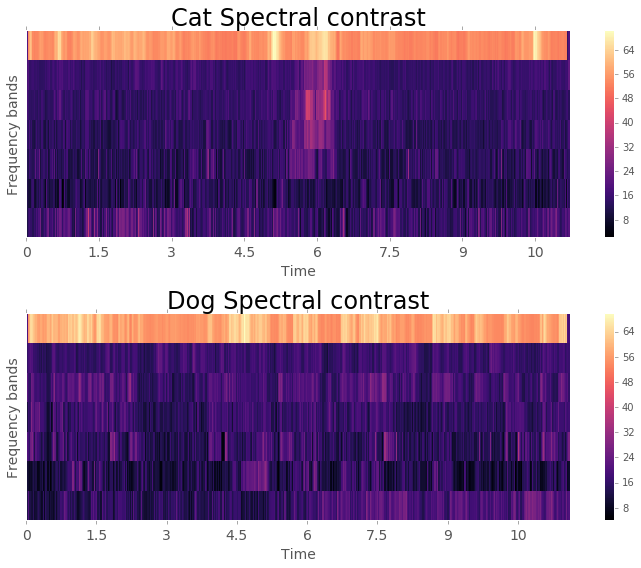

In [25]:
import librosa.display

plt.figure(figsize=(10, 8))
plt.subplot(2, 1, 1)
cat, sample_rate = librosa.load(base_dir+"cats_dogs/"+"cat_1.wav")
stft = np.abs(librosa.stft(cat))
contrast = librosa.feature.spectral_contrast(S=stft, sr=sample_rate)
librosa.display.specshow(contrast, x_axis='time')
plt.colorbar()
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.xlabel('Time', fontsize = 14)
plt.ylabel('Frequency bands', fontsize = 14)
plt.title('Cat Spectral contrast', fontsize = 24)
plt.tight_layout()

plt.subplot(2, 1, 2)
dog, sample_rate = librosa.load(base_dir+"cats_dogs/"+"dog_barking_1.wav")
stft = np.abs(librosa.stft(dog))
contrast = librosa.feature.spectral_contrast(S=stft, sr=sample_rate)
librosa.display.specshow(contrast, x_axis='time')
plt.colorbar()
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.xlabel('Time', fontsize = 14)
plt.ylabel('Frequency bands', fontsize=14)
plt.title('Dog Spectral contrast', fontsize = 24)
plt.tight_layout()

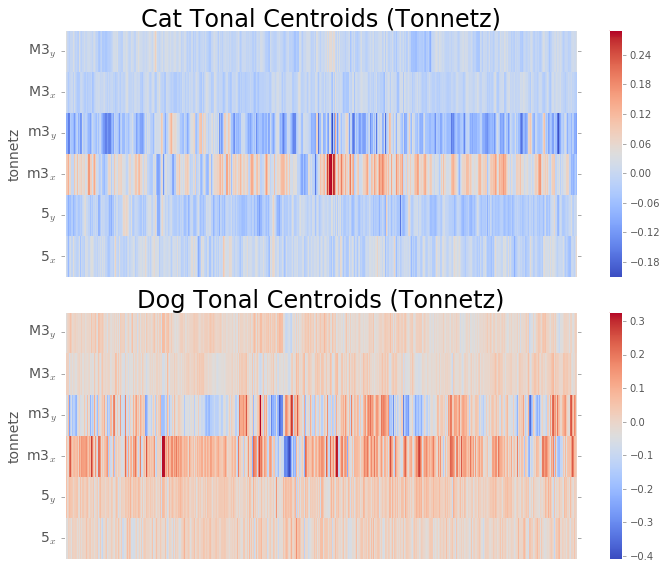

In [29]:
plt.figure(figsize=(10, 8))
plt.subplot(2, 1, 1)
cat, sample_rate = librosa.load(base_dir+"cats_dogs/"+"cat_1.wav")
tonnetz = librosa.feature.tonnetz(y=librosa.effects.harmonic(cat),sr=sample_rate)
librosa.display.specshow(tonnetz, y_axis='tonnetz')
plt.colorbar()
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.ylabel('tonnetz', fontsize = 14)
plt.title('Cat Tonal Centroids (Tonnetz)', fontsize = 24)
plt.tight_layout()

plt.subplot(2, 1, 2)
dog, sample_rate = librosa.load(base_dir+"cats_dogs/"+"dog_barking_1.wav")
tonnetz = librosa.feature.tonnetz(y=librosa.effects.harmonic(dog),sr=sample_rate)
librosa.display.specshow(tonnetz, y_axis='tonnetz')
plt.colorbar()
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.ylabel('tonnetz', fontsize = 14)
plt.title('Dog Tonal Centroids (Tonnetz)', fontsize = 24)
plt.tight_layout()

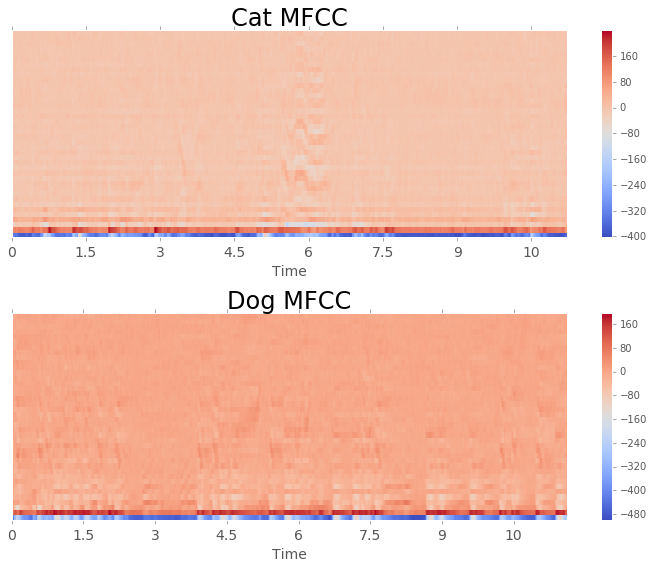

In [31]:
import librosa.display

plt.figure(figsize=(10, 8))
plt.subplot(2, 1, 1)
cat, sample_rate = librosa.load(base_dir+"cats_dogs/"+"cat_1.wav")
mfccs = librosa.feature.mfcc(y=cat, sr=sample_rate, n_mfcc=40)
librosa.display.specshow(mfccs, x_axis='time')
plt.xticks(fontsize=14)
plt.xlabel('Time', fontsize = 14)
plt.title('Cat MFCC', fontsize=24)
plt.colorbar()

plt.subplot(2, 1, 2)
dog, sample_rate = librosa.load(base_dir+"cats_dogs/"+"dog_barking_1.wav")
mfccs = librosa.feature.mfcc(y=dog, sr=sample_rate, n_mfcc=40)
librosa.display.specshow(mfccs, x_axis='time')
plt.xticks(fontsize=14)
plt.xlabel('Time', fontsize = 14)
plt.title('Dog MFCC', fontsize=24)
plt.colorbar()

plt.tight_layout()

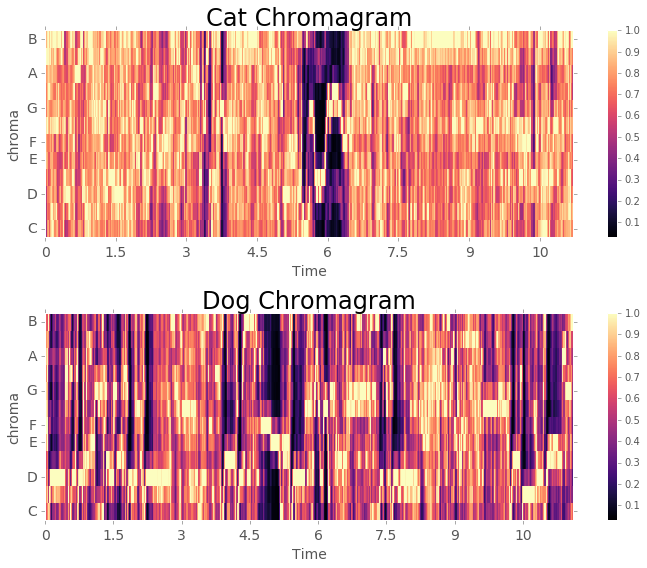

In [32]:
plt.figure(figsize=(10, 8))
plt.subplot(2, 1, 1)
cat, sample_rate = librosa.load(base_dir+"cats_dogs/"+"cat_1.wav")
stft = np.abs(librosa.stft(cat))
chroma = librosa.feature.chroma_stft(S=stft, sr=sample_rate)
librosa.display.specshow(chroma, y_axis='chroma', x_axis='time')
plt.colorbar()
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.xlabel('Time', fontsize = 14)
plt.ylabel('chroma', fontsize = 14)
plt.title('Cat Chromagram', fontsize = 24)
plt.tight_layout()

plt.subplot(2, 1, 2)
dog, sample_rate = librosa.load(base_dir+"cats_dogs/"+"dog_barking_1.wav")
stft = np.abs(librosa.stft(dog))
chroma = librosa.feature.chroma_stft(S=stft, sr=sample_rate)
librosa.display.specshow(chroma, y_axis='chroma', x_axis='time')
plt.colorbar()
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.xlabel('Time', fontsize = 14)
plt.ylabel('chroma', fontsize=14)
plt.title('Dog Chromagram', fontsize = 24)
plt.tight_layout()

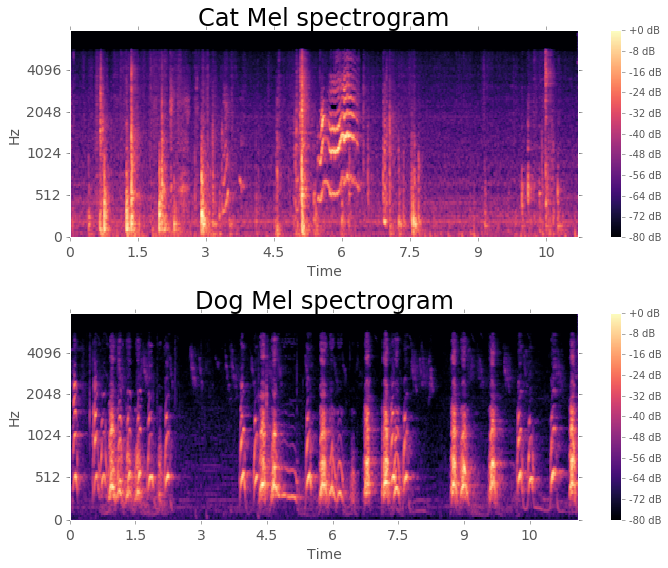

In [30]:
import librosa.display

plt.figure(figsize=(10, 8))
plt.subplot(2, 1, 1)
cat, sample_rate = librosa.load(base_dir+"cats_dogs/"+"cat_1.wav")
mel = librosa.feature.melspectrogram(cat, sr=sample_rate)
librosa.display.specshow(librosa.power_to_db(mel, ref=np.max), y_axis='mel', fmax=8000,x_axis='time')
plt.colorbar(format='%+2.0f dB')
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.xlabel('Time', fontsize = 14)
plt.ylabel('Hz', fontsize = 14)
plt.title('Cat Mel spectrogram', fontsize = 24)
plt.tight_layout()

plt.subplot(2, 1, 2)
dog, sample_rate = librosa.load(base_dir+"cats_dogs/"+"dog_barking_1.wav")
mel = librosa.feature.melspectrogram(dog, sr=sample_rate)
librosa.display.specshow(librosa.power_to_db(mel, ref=np.max), y_axis='mel', fmax=8000,x_axis='time')
plt.colorbar(format='%+2.0f dB')
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.xlabel('Time', fontsize = 14)
plt.ylabel('Hz', fontsize = 14)
plt.title('Dog Mel spectrogram', fontsize = 24)
plt.tight_layout()

In [8]:
X = preprocessing.scale(X)

In [9]:
from sklearn.model_selection import StratifiedKFold
print('K-Fold type: {}'.format('Stratified'))
kf = StratifiedKFold(n_splits=5)
fid = 0
for train_index, test_index in kf.split(X, y):    
    fid +=1 
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]  
    print('fold # {}, y_train_mean: {}, y_test_mean: {}'.format(fid, np.mean(y_train),np.mean(y_test)))

K-Fold type: Stratified
fold # 1, y_train_mean: 0.4072398190045249, y_test_mean: 0.4107142857142857
fold # 2, y_train_mean: 0.4072398190045249, y_test_mean: 0.4107142857142857
fold # 3, y_train_mean: 0.4072398190045249, y_test_mean: 0.4107142857142857
fold # 4, y_train_mean: 0.4099099099099099, y_test_mean: 0.4
fold # 5, y_train_mean: 0.4080717488789238, y_test_mean: 0.4074074074074074


## Model fitting

In [10]:
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVR
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.svm import SVC
from sklearn.linear_model import ElasticNet
from sklearn.linear_model import SGDClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import VotingClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.neural_network import MLPClassifier


from sklearn import model_selection
from sklearn.model_selection import cross_val_score
from sklearn.metrics import accuracy_score
import collections
import numpy as np
from scipy import stats
import matplotlib.pyplot as plt

In [11]:
# Train and Test models
from sklearn.metrics import confusion_matrix
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve, auc
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import average_precision_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
from scipy import interp
from sklearn.metrics import accuracy_score as acc
from sklearn.metrics import mean_squared_error as mse

%matplotlib inline
plt.style.use('ggplot')

In [12]:
Mean_fpr_tpr = {}
All_test_pred = {}

### AdaBoost

In [13]:
CV_fpr_tpr = []
CV_fpr_tpr_thrsh = []
CV_CM_test=[]
CV_Acc_test=[]
CV_AUC_test=[]
CV_feat_imp = []
CM_total = np.array([[0.0,0.0],[0.0,0.0]], np.int64)

model_choice = "AdaBoost"
np.random.seed(100)

y_test = []
y_test_pred = []
subject_id = []
for train, test in kf.split(X, y):
    y_test.extend(y[test])
    subject_id.extend(np.array(path)[test])
    
    model_clf = AdaBoostClassifier(base_estimator=DecisionTreeClassifier(max_depth=3), random_state=100)
    hyper_params = {'learning_rate':[0.1, 0.5, 1.], 'n_estimators':[100, 200, 300],
                    'base_estimator__min_samples_split':[6,9,12], 'base_estimator__max_depth' : [1,3,5]}
    clf = model_selection.GridSearchCV(model_clf, hyper_params,cv=3,verbose=0, n_jobs=20)
    clf.fit(X[train],y[train])
    print(clf.best_params_)
    
    y_pred = clf.predict(X[test])
    y_test_pred.extend(y_pred)
    y_pred_prob = clf.predict_proba(X[test])
    feat_imp = clf.best_estimator_.feature_importances_
    
    CV_Acc_test.append(acc(y[test], y_pred))
    
    fpr, tpr, thresholds = roc_curve(y[test], y_pred_prob[:,1])
    CV_fpr_tpr.append((fpr,tpr))
    CV_fpr_tpr_thrsh.append(thresholds)
    CV_AUC_test.append(roc_auc_score(y[test], y_pred_prob[:,1]))
    
    CM_test = confusion_matrix(y[test],y_pred)
    CM_total = CM_total + CM_test
    CV_CM_test.append(CM_test)
    
    CV_feat_imp.append(feat_imp)

All_test_pred[model_choice] = y_test_pred

{'learning_rate': 0.5, 'n_estimators': 300, 'base_estimator__max_depth': 1, 'base_estimator__min_samples_split': 6}
{'learning_rate': 1.0, 'n_estimators': 200, 'base_estimator__max_depth': 5, 'base_estimator__min_samples_split': 12}
{'learning_rate': 1.0, 'n_estimators': 100, 'base_estimator__max_depth': 3, 'base_estimator__min_samples_split': 6}
{'learning_rate': 1.0, 'n_estimators': 100, 'base_estimator__max_depth': 3, 'base_estimator__min_samples_split': 9}
{'learning_rate': 1.0, 'n_estimators': 300, 'base_estimator__max_depth': 3, 'base_estimator__min_samples_split': 9}


#### Model Analysis

In [14]:
print('Acc (mean, std_err): {:04.2f}, {:04.2f}'.format(np.mean(CV_Acc_test), np.std(CV_Acc_test)))
print('AUC (mean, std_err): {:04.2f}, {:04.2f}'.format(np.mean(CV_AUC_test), np.std(CV_AUC_test)))
print('Confusion Matrix:', CM_total)

ppv = CM_total[1][1] / (CM_total[0][1] + CM_total[1][1])
npv = CM_total[0][0] / (CM_total[0][0] + CM_total[1][0])
sens = CM_total[1][1] / (CM_total[1][0] + CM_total[1][1])
spec = CM_total[0][0] / (CM_total[0][0] + CM_total[0][1])
print('Sensitivity: {:04.2f}'.format(sens))
print('Specificity: {:04.2f}'.format(spec))
print('PPV: {:04.2f}'.format(ppv))
print('NPV: {:04.2f}'.format(npv))

Acc (mean, std_err): 0.90, 0.03
AUC (mean, std_err): 0.96, 0.02
Confusion Matrix: [[157   7]
 [ 22  91]]
Sensitivity: 0.81
Specificity: 0.96
PPV: 0.93
NPV: 0.88


plotting :Confusion_Matrix


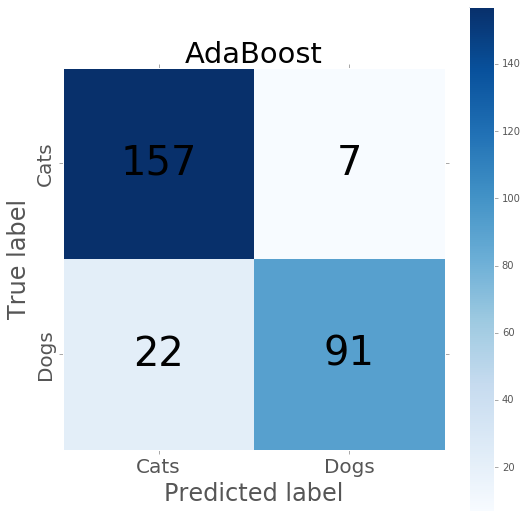

In [15]:
plot_name = 'Confusion_Matrix'
print('plotting :{}'.format(plot_name))
plt.rcParams['figure.figsize'] = (7, 7)
class_labels = ['Cats','Dogs']
plt.imshow(CM_total, interpolation='nearest',cmap=plt.cm.Blues)
plt.title(model_choice, fontsize = 29)
plt.colorbar()
tick_marks = np.arange(len(class_labels))
plt.xticks(tick_marks, class_labels, fontsize = 20)
plt.yticks(tick_marks,class_labels, rotation=90, fontsize = 20)
plt.tight_layout(0)
plt.ylabel('True label', fontsize = 24)
plt.xlabel('Predicted label', fontsize = 24)
plt.grid(0)
for x_lab in range(2):
    for y_lab in range(2):
        plt.text(y_lab, x_lab, CM_total[x_lab][y_lab], horizontalalignment='center',verticalalignment='center',fontsize=40)

plotting :ROC


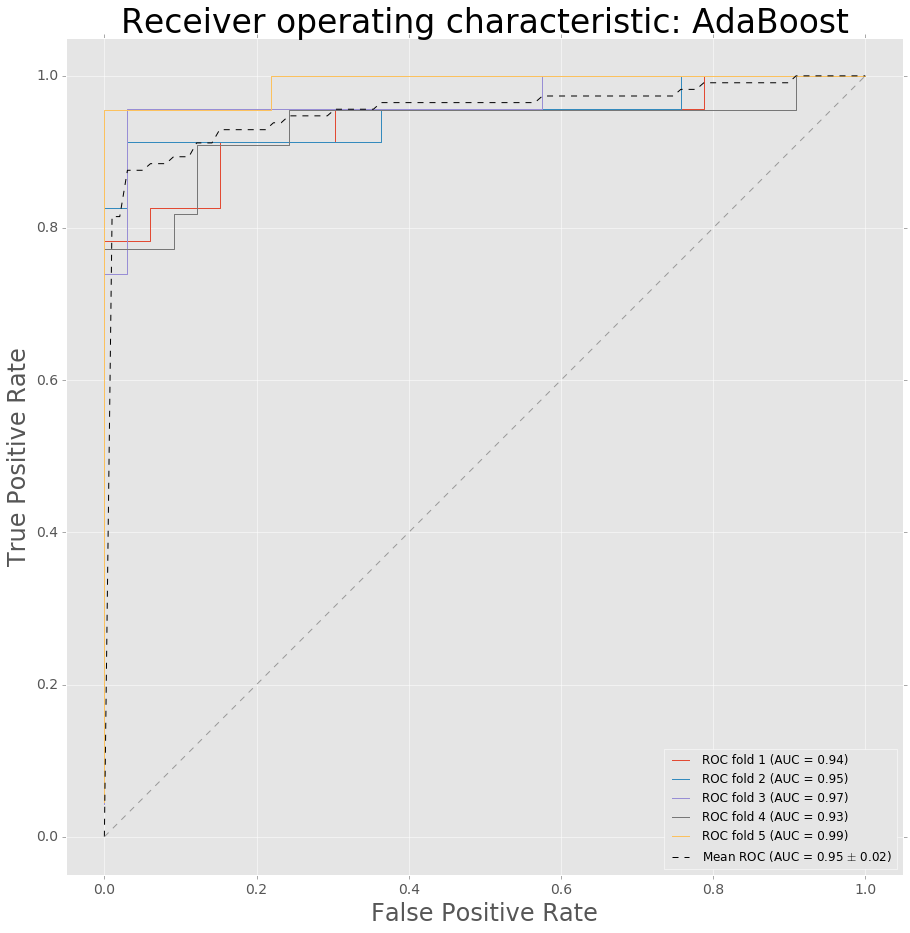

In [16]:
plot_name = 'ROC'
print('plotting :{}'.format(plot_name))
plt.rcParams['figure.figsize'] = (15, 15)
mean_fpr = np.linspace(0, 1, 100)
tprs = []
aucs = []
for i, (fpr, tpr) in enumerate(CV_fpr_tpr):                
    tprs.append(interp(mean_fpr, fpr, tpr))
    roc_auc = auc(fpr, tpr)
    aucs.append(roc_auc)
    plt.plot(fpr, tpr, lw=1, label='ROC fold %d (AUC = %0.2f)' % (i+1, roc_auc))
mean_tpr = np.mean(tprs, axis=0)
mean_tpr[0] = 0.0
mean_tpr[-1] = 1.0
Mean_fpr_tpr[model_choice] = mean_tpr
mean_auc = auc(mean_fpr, mean_tpr)
std_auc = np.std(aucs)
plt.plot(mean_fpr, mean_tpr, 'k--', label=r'Mean ROC (AUC = %0.2f $\pm$ %0.2f)' % (mean_auc, std_auc))
plt.plot([0, 1], [0, 1], '--', color=(0.6, 0.6, 0.6))
plt.xlim([-0.05, 1.05])
plt.xticks(fontsize=14)
plt.ylim([-0.05, 1.05])
plt.yticks(fontsize=14)
plt.xlabel('False Positive Rate', fontsize = 24)
plt.ylabel('True Positive Rate', fontsize = 24)
plt.title('Receiver operating characteristic: {}'.format(model_choice), fontsize = 33)
plt.legend(loc="lower right")
plt.show()

In [20]:
cv_mean_importance = np.column_stack((feature_names, np.mean(CV_feat_imp, axis=0)))
cv_mean_importance = np.vstack(sorted(cv_mean_importance,key=lambda x: x[1].astype(float)))
print(cv_mean_importance[-10:])

[['mfcc22' '0.014638607245848695']
 ['mel23' '0.015116156297209693']
 ['mel3' '0.015543986938279856']
 ['mel19' '0.01602340101294806']
 ['contrast0' '0.01649400979953079']
 ['tonnetz1' '0.01790477143126293']
 ['tonnetz0' '0.02134020553633088']
 ['mel22' '0.030705125280522595']
 ['contrast5' '0.03108118044700911']
 ['mfcc3' '0.04571970356329892']]


### SVM

In [18]:
CV_fpr_tpr = []
CV_fpr_tpr_thrsh = []
CV_CM_test=[]
CV_Acc_test=[]
CV_AUC_test=[] 
CV_feat_imp = []
CM_total = np.array([[0.0,0.0],[0.0,0.0]], np.int64)

model_choice = "SVM"
np.random.seed(100)

y_test = []
y_test_pred = []
subject_id = []
for train, test in kf.split(X, y):
    y_test.append(y[test])
    subject_id.extend(np.array(path)[test])
    
    model_clf = SVC(probability = True, kernel='linear', class_weight='balanced')
    hyper_params = {'C':[0.1,1,10,25], 'tol':[0.0001, 0.001, 0.01]}
    clf = model_selection.GridSearchCV(model_clf, hyper_params,cv=3,verbose=0, n_jobs=20)
    clf.fit(X[train],y[train])
    print(clf.best_params_)
    y_pred = clf.predict(X[test])
    y_test_pred.extend(y_pred)
    y_pred_prob = clf.predict_proba(X[test])
    feat_imp = clf.best_estimator_.coef_
    
    CV_Acc_test.append(acc(y[test], y_pred))
    
    fpr, tpr, thresholds = roc_curve(y[test], y_pred_prob[:,1])
    CV_fpr_tpr.append((fpr,tpr))
    CV_fpr_tpr_thrsh.append(thresholds)
    CV_AUC_test.append(roc_auc_score(y[test], y_pred_prob[:,1]))
    
    CM_test = confusion_matrix(y[test],y_pred)
    CM_total = CM_total + CM_test
    CV_CM_test.append(CM_test)
    
    CV_feat_imp.append(feat_imp)
    
All_test_pred[model_choice] = y_test_pred

{'C': 0.1, 'tol': 0.0001}
{'C': 0.1, 'tol': 0.0001}
{'C': 0.1, 'tol': 0.0001}
{'C': 0.1, 'tol': 0.0001}
{'C': 1, 'tol': 0.0001}


#### Model Analysis

In [19]:
print('Acc (mean, std_err): {:04.2f}, {:04.2f}'.format(np.mean(CV_Acc_test), np.std(CV_Acc_test)))
print('AUC (mean, std_err): {:04.2f}, {:04.2f}'.format(np.mean(CV_AUC_test), np.std(CV_AUC_test)))
print('Confusion Matrix:', CM_total)

ppv = CM_total[1][1] / (CM_total[0][1] + CM_total[1][1])
npv = CM_total[0][0] / (CM_total[0][0] + CM_total[1][0])
sens = CM_total[1][1] / (CM_total[1][0] + CM_total[1][1])
spec = CM_total[0][0] / (CM_total[0][0] + CM_total[0][1])
print('Sensitivity: {:04.2f}'.format(sens))
print('Specificity: {:04.2f}'.format(spec))
print('PPV: {:04.2f}'.format(ppv))
print('NPV: {:04.2f}'.format(npv))

Acc (mean, std_err): 0.85, 0.03
AUC (mean, std_err): 0.91, 0.04
Confusion Matrix: [[143  21]
 [ 20  93]]
Sensitivity: 0.82
Specificity: 0.87
PPV: 0.82
NPV: 0.88


plotting :Confusion_Matrix


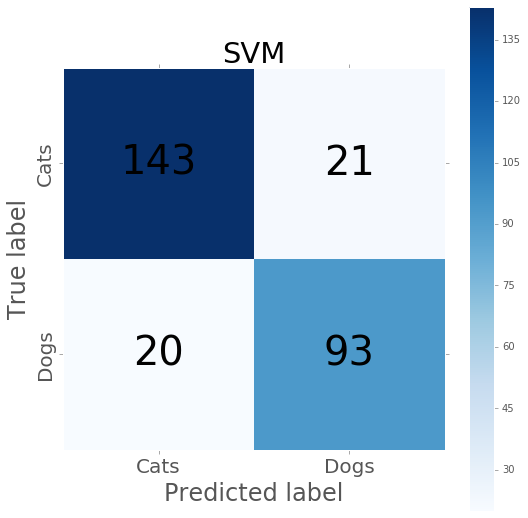

In [20]:
plot_name = 'Confusion_Matrix'
print('plotting :{}'.format(plot_name))
plt.rcParams['figure.figsize'] = (7, 7)
class_labels = ['Cats','Dogs']
plt.imshow(CM_total, interpolation='nearest',cmap=plt.cm.Blues)
plt.title(model_choice, fontsize = 29)
plt.colorbar()
tick_marks = np.arange(len(class_labels))
plt.xticks(tick_marks, class_labels, fontsize = 20)
plt.yticks(tick_marks,class_labels, rotation=90, fontsize = 20)
plt.tight_layout(0)
plt.ylabel('True label', fontsize = 24)
plt.xlabel('Predicted label', fontsize = 24)
plt.grid(0)
for x_lab in range(2):
    for y_lab in range(2):
        plt.text(y_lab, x_lab, CM_total[x_lab][y_lab], horizontalalignment='center',verticalalignment='center',fontsize=40)

plotting :ROC


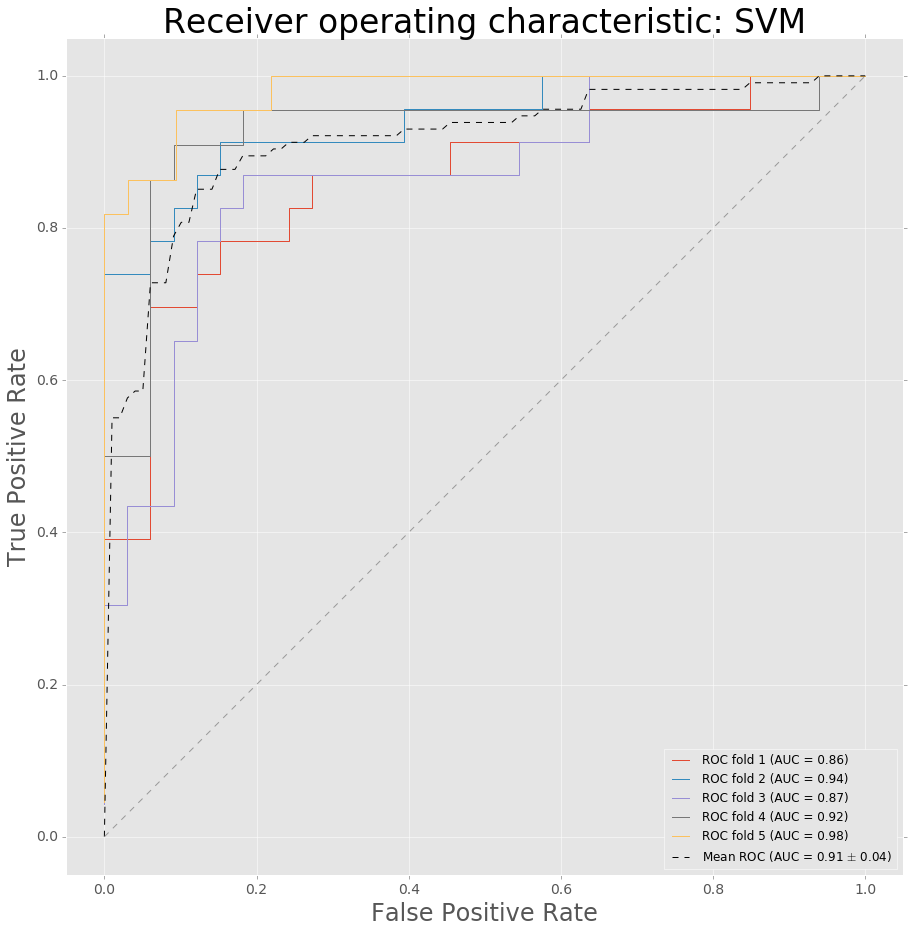

In [21]:
plot_name = 'ROC'
print('plotting :{}'.format(plot_name))
plt.rcParams['figure.figsize'] = (15, 15)
mean_fpr = np.linspace(0, 1, 100)
tprs = []
aucs = []
for i, (fpr, tpr) in enumerate(CV_fpr_tpr):                
    tprs.append(interp(mean_fpr, fpr, tpr))
    roc_auc = auc(fpr, tpr)
    aucs.append(roc_auc)
    plt.plot(fpr, tpr, lw=1, label='ROC fold %d (AUC = %0.2f)' % (i+1, roc_auc))
mean_tpr = np.mean(tprs, axis=0)
mean_tpr[0] = 0.0
mean_tpr[-1] = 1.0
Mean_fpr_tpr[model_choice] = mean_tpr
mean_auc = auc(mean_fpr, mean_tpr)
std_auc = np.std(aucs)
plt.plot(mean_fpr, mean_tpr, 'k--', label=r'Mean ROC (AUC = %0.2f $\pm$ %0.2f)' % (mean_auc, std_auc))
plt.plot([0, 1], [0, 1], '--', color=(0.6, 0.6, 0.6))
plt.xlim([-0.05, 1.05])
plt.xticks(fontsize=14)
plt.ylim([-0.05, 1.05])
plt.yticks(fontsize=14)
plt.xlabel('False Positive Rate', fontsize = 24)
plt.ylabel('True Positive Rate', fontsize = 24)
plt.title('Receiver operating characteristic: {}'.format(model_choice), fontsize = 33)
plt.legend(loc="lower right")
plt.show()

## Lasso

In [22]:
CV_fpr_tpr = []
CV_fpr_tpr_thrsh = []
CV_CM_test=[]
CV_Acc_test=[]
CV_AUC_test=[]
CV_feat_imp = []
CM_total = np.array([[0.0,0.0],[0.0,0.0]], np.int64)

model_choice = "Lasso"
np.random.seed(100)

y_test = []
y_test_pred = []
subject_id = []
for train, test in kf.split(X, y):
    y_test.append(y[test])
    subject_id.extend(np.array(path)[test])
    
    model_clf = LogisticRegression(penalty='l1',class_weight='balanced')
    hyper_params = {'C':[0.01,.1,1,10], 'tol':[0.0001, 0.001, 0.01]} 
    clf = model_selection.GridSearchCV(model_clf, hyper_params,cv=3,verbose=0, n_jobs=20)
    clf.fit(X[train],y[train])
    print(clf.best_params_)
    y_pred = clf.predict(X[test])
    y_test_pred.extend(y_pred)
    y_pred_prob = clf.predict_proba(X[test])
    feat_imp = clf.best_estimator_.coef_
    
    CV_Acc_test.append(acc(y[test], y_pred))
    
    fpr, tpr, thresholds = roc_curve(y[test], y_pred_prob[:,1])
    CV_fpr_tpr.append((fpr,tpr))
    CV_fpr_tpr_thrsh.append(thresholds)
    CV_AUC_test.append(roc_auc_score(y[test], y_pred_prob[:,1]))
    
    CM_test = confusion_matrix(y[test],y_pred)
    CM_total = CM_total + CM_test
    CV_CM_test.append(CM_test)
    
    CV_feat_imp.append(feat_imp)
    
All_test_pred[model_choice] = y_test_pred

{'C': 1, 'tol': 0.0001}
{'C': 1, 'tol': 0.0001}
{'C': 1, 'tol': 0.01}
{'C': 1, 'tol': 0.01}
{'C': 1, 'tol': 0.001}


#### Model Analysis

In [23]:
print('Acc (mean, std_err): {:04.2f}, {:04.2f}'.format(np.mean(CV_Acc_test), np.std(CV_Acc_test)))
print('AUC (mean, std_err): {:04.2f}, {:04.2f}'.format(np.mean(CV_AUC_test), np.std(CV_AUC_test)))
print('Confusion Matrix:', CM_total)

ppv = CM_total[1][1] / (CM_total[0][1] + CM_total[1][1])
npv = CM_total[0][0] / (CM_total[0][0] + CM_total[1][0])
sens = CM_total[1][1] / (CM_total[1][0] + CM_total[1][1])
spec = CM_total[0][0] / (CM_total[0][0] + CM_total[0][1])
print('Sensitivity: {:04.2f}'.format(sens))
print('Specificity: {:04.2f}'.format(spec))
print('PPV: {:04.2f}'.format(ppv))
print('NPV: {:04.2f}'.format(npv))

Acc (mean, std_err): 0.88, 0.02
AUC (mean, std_err): 0.94, 0.03
Confusion Matrix: [[148  16]
 [ 16  97]]
Sensitivity: 0.86
Specificity: 0.90
PPV: 0.86
NPV: 0.90


plotting :Confusion_Matrix


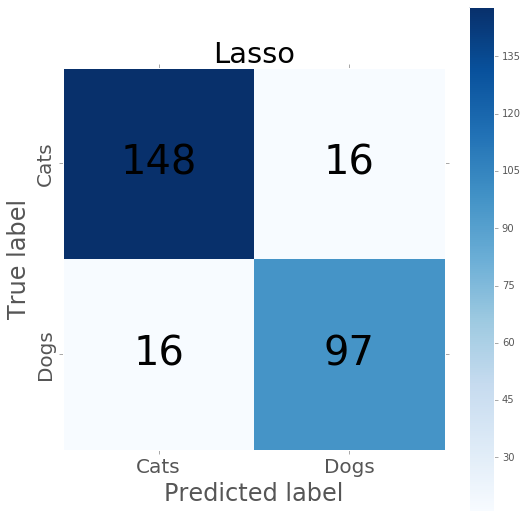

In [24]:
plot_name = 'Confusion_Matrix'
print('plotting :{}'.format(plot_name))
plt.rcParams['figure.figsize'] = (7, 7)
class_labels = ['Cats','Dogs']
plt.imshow(CM_total, interpolation='nearest',cmap=plt.cm.Blues)
plt.title(model_choice, fontsize = 29)
plt.colorbar()
tick_marks = np.arange(len(class_labels))
plt.xticks(tick_marks, class_labels, fontsize = 20)
plt.yticks(tick_marks,class_labels, rotation=90, fontsize = 20)
plt.tight_layout(0)
plt.ylabel('True label', fontsize = 24)
plt.xlabel('Predicted label', fontsize = 24)
plt.grid(0)
for x_lab in range(2):
    for y_lab in range(2):
        plt.text(y_lab, x_lab, CM_total[x_lab][y_lab], horizontalalignment='center',verticalalignment='center',fontsize=40)

plotting :ROC


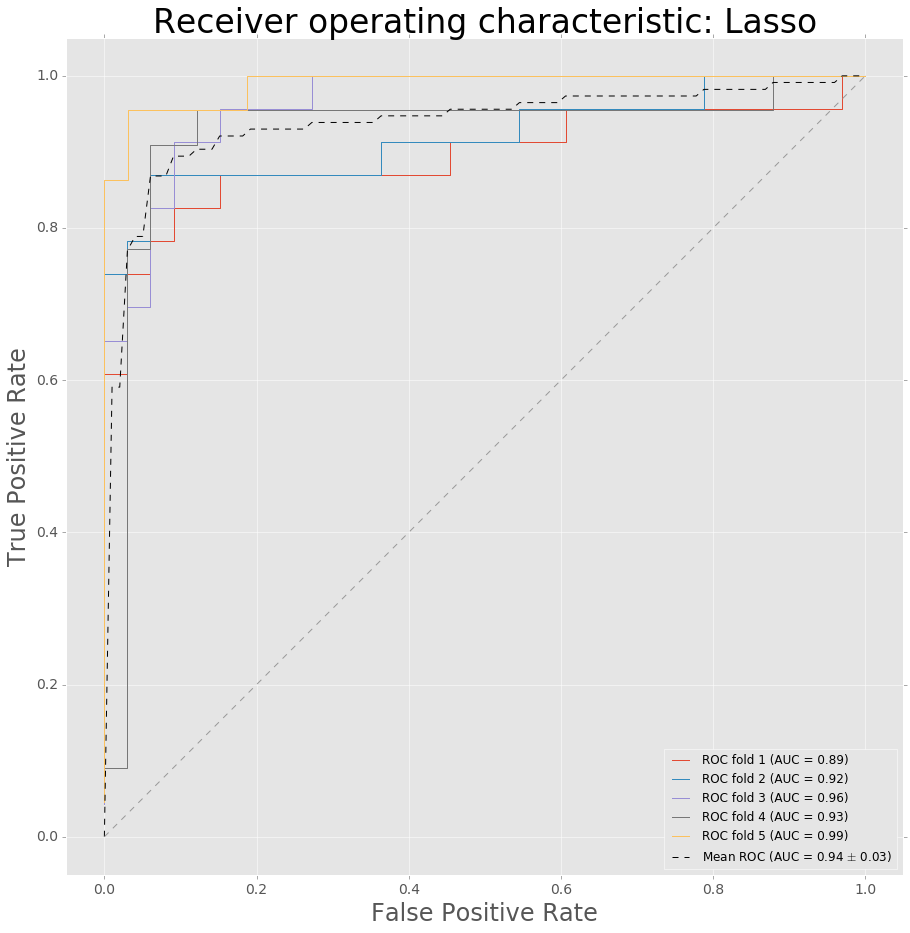

In [25]:
plot_name = 'ROC'
print('plotting :{}'.format(plot_name))
plt.rcParams['figure.figsize'] = (15, 15)
mean_fpr = np.linspace(0, 1, 100)
tprs = []
aucs = []
for i, (fpr, tpr) in enumerate(CV_fpr_tpr):                
    tprs.append(interp(mean_fpr, fpr, tpr))
    roc_auc = auc(fpr, tpr)
    aucs.append(roc_auc)
    plt.plot(fpr, tpr, lw=1, label='ROC fold %d (AUC = %0.2f)' % (i+1, roc_auc))
mean_tpr = np.mean(tprs, axis=0)
mean_tpr[0] = 0.0
mean_tpr[-1] = 1.0
Mean_fpr_tpr[model_choice] = mean_tpr
mean_auc = auc(mean_fpr, mean_tpr)
std_auc = np.std(aucs)
plt.plot(mean_fpr, mean_tpr, 'k--', label=r'Mean ROC (AUC = %0.2f $\pm$ %0.2f)' % (mean_auc, std_auc))
plt.plot([0, 1], [0, 1], '--', color=(0.6, 0.6, 0.6))
plt.xlim([-0.05, 1.05])
plt.xticks(fontsize=14)
plt.ylim([-0.05, 1.05])
plt.yticks(fontsize=14)
plt.xlabel('False Positive Rate', fontsize = 24)
plt.ylabel('True Positive Rate', fontsize = 24)
plt.title('Receiver operating characteristic: {}'.format(model_choice), fontsize = 33)
plt.legend(loc="lower right")
plt.show()

## Random Forest

In [26]:
CV_fpr_tpr = []
CV_fpr_tpr_thrsh = []
CV_CM_test=[]
CV_Acc_test=[]
CV_AUC_test=[] 
CV_feat_imp = []
CM_total = np.array([[0.0,0.0],[0.0,0.0]], np.int64)

model_choice = "Random Forest"
np.random.seed(100)

y_test = []
y_test_pred = []
subject_id = []
for train, test in kf.split(X, y):
    y_test.append(y[test])
    subject_id.extend(np.array(path)[test])
    
    model_clf = RandomForestClassifier(class_weight='balanced' )
    hyper_params = {'n_estimators':[10,50,100],'min_samples_split':[2,4,8], 'max_features':[4,8,10], 'max_depth':[None,1,3,5]}
    clf = model_selection.GridSearchCV(model_clf, hyper_params,cv=3,verbose=0, n_jobs=20)
    clf.fit(X[train],y[train])
    print(clf.best_params_)
    y_pred = clf.predict(X[test])
    y_test_pred.extend(y_pred)
    y_pred_prob = clf.predict_proba(X[test])
    feat_imp = clf.best_estimator_.feature_importances_
    
    CV_Acc_test.append(acc(y[test], y_pred))
    
    fpr, tpr, thresholds = roc_curve(y[test], y_pred_prob[:,1])
    CV_fpr_tpr.append((fpr,tpr))
    CV_fpr_tpr_thrsh.append(thresholds)
    CV_AUC_test.append(roc_auc_score(y[test], y_pred_prob[:,1]))
    
    CM_test = confusion_matrix(y[test],y_pred)
    CM_total = CM_total + CM_test
    CV_CM_test.append(CM_test)
    
    CV_feat_imp.append(feat_imp)
    
All_test_pred[model_choice] = y_test_pred

{'max_depth': None, 'min_samples_split': 4, 'n_estimators': 50, 'max_features': 8}
{'max_depth': 3, 'min_samples_split': 4, 'n_estimators': 50, 'max_features': 8}
{'max_depth': None, 'min_samples_split': 4, 'n_estimators': 100, 'max_features': 8}
{'max_depth': None, 'min_samples_split': 2, 'n_estimators': 100, 'max_features': 10}
{'max_depth': None, 'min_samples_split': 4, 'n_estimators': 50, 'max_features': 4}


#### Model Analysis

In [27]:
print('Acc (mean, std_err): {:04.2f}, {:04.2f}'.format(np.mean(CV_Acc_test), np.std(CV_Acc_test)))
print('AUC (mean, std_err): {:04.2f}, {:04.2f}'.format(np.mean(CV_AUC_test), np.std(CV_AUC_test)))
print('Confusion Matrix:', CM_total)

ppv = CM_total[1][1] / (CM_total[0][1] + CM_total[1][1])
npv = CM_total[0][0] / (CM_total[0][0] + CM_total[1][0])
sens = CM_total[1][1] / (CM_total[1][0] + CM_total[1][1])
spec = CM_total[0][0] / (CM_total[0][0] + CM_total[0][1])
print('Sensitivity: {:04.2f}'.format(sens))
print('Specificity: {:04.2f}'.format(spec))
print('PPV: {:04.2f}'.format(ppv))
print('NPV: {:04.2f}'.format(npv))

Acc (mean, std_err): 0.89, 0.04
AUC (mean, std_err): 0.95, 0.03
Confusion Matrix: [[157   7]
 [ 23  90]]
Sensitivity: 0.80
Specificity: 0.96
PPV: 0.93
NPV: 0.87


plotting :Confusion_Matrix


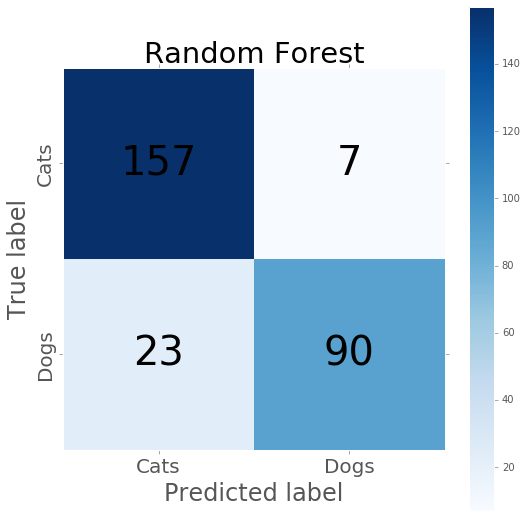

In [28]:
plot_name = 'Confusion_Matrix'
print('plotting :{}'.format(plot_name))
plt.rcParams['figure.figsize'] = (7, 7)
class_labels = ['Cats','Dogs']
plt.imshow(CM_total, interpolation='nearest',cmap=plt.cm.Blues)
plt.title(model_choice, fontsize = 29)
plt.colorbar()
tick_marks = np.arange(len(class_labels))
plt.xticks(tick_marks, class_labels, fontsize = 20)
plt.yticks(tick_marks,class_labels, rotation=90, fontsize = 20)
plt.tight_layout(0)
plt.ylabel('True label', fontsize = 24)
plt.xlabel('Predicted label', fontsize = 24)
plt.grid(0)
for x_lab in range(2):
    for y_lab in range(2):
        plt.text(y_lab, x_lab, CM_total[x_lab][y_lab], horizontalalignment='center',verticalalignment='center',fontsize=40)

plotting :ROC


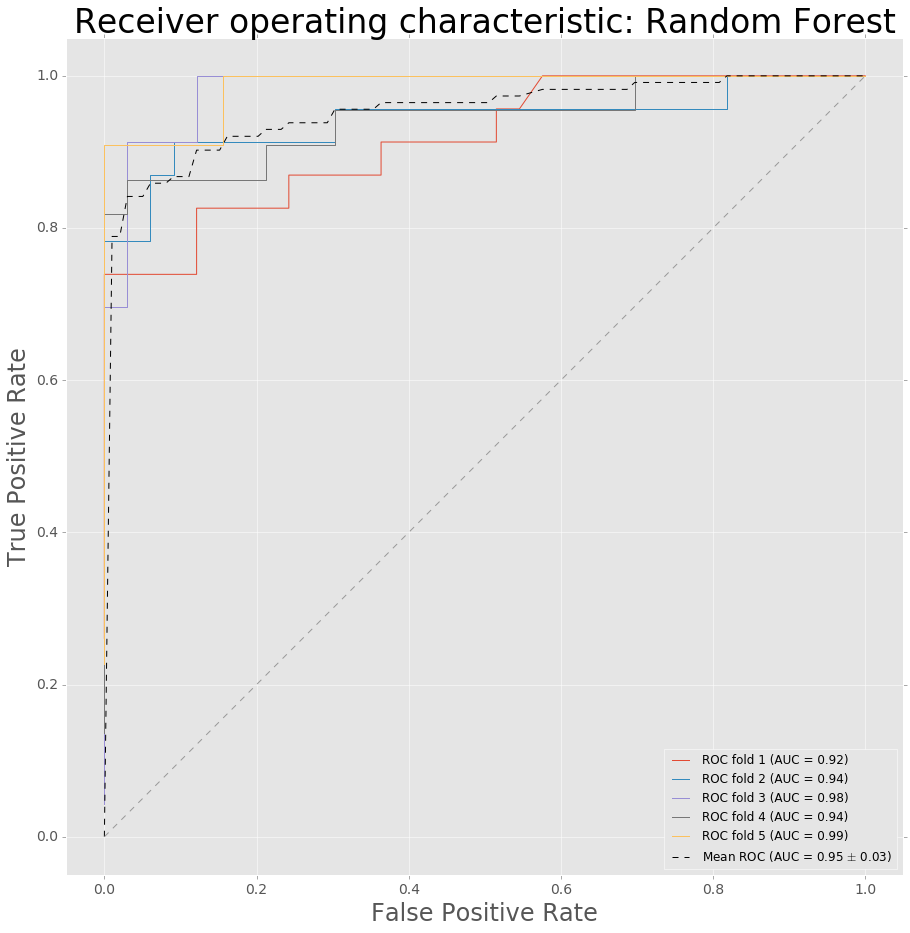

In [29]:
plot_name = 'ROC'
print('plotting :{}'.format(plot_name))
plt.rcParams['figure.figsize'] = (15, 15)
mean_fpr = np.linspace(0, 1, 100)
tprs = []
aucs = []
for i, (fpr, tpr) in enumerate(CV_fpr_tpr):                
    tprs.append(interp(mean_fpr, fpr, tpr))
    roc_auc = auc(fpr, tpr)
    aucs.append(roc_auc)
    plt.plot(fpr, tpr, lw=1, label='ROC fold %d (AUC = %0.2f)' % (i+1, roc_auc))
mean_tpr = np.mean(tprs, axis=0)
mean_tpr[0] = 0.0
mean_tpr[-1] = 1.0
Mean_fpr_tpr[model_choice] = mean_tpr
mean_auc = auc(mean_fpr, mean_tpr)
std_auc = np.std(aucs)
plt.plot(mean_fpr, mean_tpr, 'k--', label=r'Mean ROC (AUC = %0.2f $\pm$ %0.2f)' % (mean_auc, std_auc))
plt.plot([0, 1], [0, 1], '--', color=(0.6, 0.6, 0.6))
plt.xlim([-0.05, 1.05])
plt.xticks(fontsize=14)
plt.ylim([-0.05, 1.05])
plt.yticks(fontsize=14)
plt.xlabel('False Positive Rate', fontsize = 24)
plt.ylabel('True Positive Rate', fontsize = 24)
plt.title('Receiver operating characteristic: {}'.format(model_choice), fontsize = 33)
plt.legend(loc="lower right")
plt.show()

In [30]:
cv_mean_importance = np.column_stack((feature_names, np.mean(CV_feat_imp, axis=0)))
cv_mean_importance = np.vstack(sorted(cv_mean_importance,key=lambda x: x[1]))
print(cv_mean_importance[-10:])

[['mel26' '0.01524333353678604']
 ['mel28' '0.015382170260060493']
 ['mel20' '0.01597995529264532']
 ['mel24' '0.017148829617134747']
 ['mfcc5' '0.01772652944504361']
 ['mel25' '0.02364507819911122']
 ['mel21' '0.024535042701426812']
 ['mfcc3' '0.025426879209790428']
 ['mel23' '0.02720745305683473']
 ['mel22' '0.03273597880886051']]


## Neural Network

In [33]:
from sklearn.model_selection import RandomizedSearchCV

CV_fpr_tpr = []
CV_fpr_tpr_thrsh = []
CV_CM_test=[]
CV_Acc_test=[]
CV_AUC_test=[]
CV_feat_imp = []
CM_total = np.array([[0.0,0.0],[0.0,0.0]], np.int64)

model_choice = "Neural Network"
np.random.seed(100)

y_test = []
y_test_pred = []
subject_id = []
for train, test in kf.split(X, y):
    y_test.append(y[test])
    subject_id.extend(np.array(path)[test])
    
    model_clf = MLPClassifier(solver = 'sgd', max_iter = 300, random_state=50)
    hyper_params = {'hidden_layer_sizes':[50, 100, 200, 400, 600], 'alpha':[0.001, 0.01, 0.1, 1.0]}
    clf = model_selection.RandomizedSearchCV(model_clf, hyper_params,cv=3,verbose=0, n_jobs=20, random_state=100)
    clf.fit(X[train],y[train])
    print(clf.best_params_)
    y_pred = clf.predict(X[test])
    y_test_pred.extend(y_pred)
    y_pred_prob = clf.predict_proba(X[test])
    feat_imp = clf.best_estimator_.coefs_
    
    CV_Acc_test.append(acc(y[test], y_pred))
    
    fpr, tpr, thresholds = roc_curve(y[test], y_pred_prob[:,1])
    CV_fpr_tpr.append((fpr,tpr))
    CV_fpr_tpr_thrsh.append(thresholds)
    CV_AUC_test.append(roc_auc_score(y[test], y_pred_prob[:,1]))
    
    CM_test = confusion_matrix(y[test],y_pred)
    CM_total = CM_total + CM_test
    CV_CM_test.append(CM_test)
    
    CV_feat_imp.append(feat_imp)
    
All_test_pred[model_choice] = y_test_pred

/home/c25yuan/.local/lib/python3.5/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
/home/c25yuan/.local/lib/python3.5/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
/home/c25yuan/.local/lib/python3.5/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
/home/c25yuan/.local/lib/python3.5/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  %

{'alpha': 1.0, 'hidden_layer_sizes': 200}


/home/c25yuan/.local/lib/python3.5/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
/home/c25yuan/.local/lib/python3.5/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
/home/c25yuan/.local/lib/python3.5/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
/home/c25yuan/.local/lib/python3.5/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  %

{'alpha': 1.0, 'hidden_layer_sizes': 100}


/home/c25yuan/.local/lib/python3.5/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
/home/c25yuan/.local/lib/python3.5/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
/home/c25yuan/.local/lib/python3.5/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
/home/c25yuan/.local/lib/python3.5/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  %

{'alpha': 1.0, 'hidden_layer_sizes': 600}


/home/c25yuan/.local/lib/python3.5/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
/home/c25yuan/.local/lib/python3.5/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
/home/c25yuan/.local/lib/python3.5/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
/home/c25yuan/.local/lib/python3.5/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  %

{'alpha': 1.0, 'hidden_layer_sizes': 600}


/home/c25yuan/.local/lib/python3.5/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
/home/c25yuan/.local/lib/python3.5/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
/home/c25yuan/.local/lib/python3.5/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
/home/c25yuan/.local/lib/python3.5/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  %

{'alpha': 1.0, 'hidden_layer_sizes': 600}


/home/c25yuan/.local/lib/python3.5/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


#### Model Analysis

In [34]:
print('Acc (mean, std_err): {:04.2f}, {:04.2f}'.format(np.mean(CV_Acc_test), np.std(CV_Acc_test)))
print('AUC (mean, std_err): {:04.2f}, {:04.2f}'.format(np.mean(CV_AUC_test), np.std(CV_AUC_test)))
print('Confusion Matrix:', CM_total)

ppv = CM_total[1][1] / (CM_total[0][1] + CM_total[1][1])
npv = CM_total[0][0] / (CM_total[0][0] + CM_total[1][0])
sens = CM_total[1][1] / (CM_total[1][0] + CM_total[1][1])
spec = CM_total[0][0] / (CM_total[0][0] + CM_total[0][1])
print('Sensitivity: {:04.2f}'.format(sens))
print('Specificity: {:04.2f}'.format(spec))
print('PPV: {:04.2f}'.format(ppv))
print('NPV: {:04.2f}'.format(npv))

Acc (mean, std_err): 0.90, 0.03
AUC (mean, std_err): 0.94, 0.03
Confusion Matrix: [[156   8]
 [ 19  94]]
Sensitivity: 0.83
Specificity: 0.95
PPV: 0.92
NPV: 0.89


plotting :Confusion_Matrix


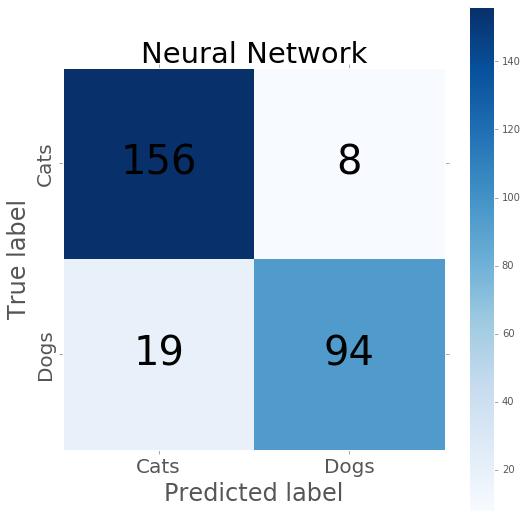

In [35]:
plot_name = 'Confusion_Matrix'
print('plotting :{}'.format(plot_name))
plt.rcParams['figure.figsize'] = (7, 7)
class_labels = ['Cats','Dogs']
plt.imshow(CM_total, interpolation='nearest',cmap=plt.cm.Blues)
plt.title(model_choice, fontsize = 29)
plt.colorbar()
tick_marks = np.arange(len(class_labels))
plt.xticks(tick_marks, class_labels, fontsize = 20)
plt.yticks(tick_marks,class_labels, rotation=90, fontsize = 20)
plt.tight_layout(0)
plt.ylabel('True label', fontsize = 24)
plt.xlabel('Predicted label', fontsize = 24)
plt.grid(0)
for x_lab in range(2):
    for y_lab in range(2):
        plt.text(y_lab, x_lab, CM_total[x_lab][y_lab], horizontalalignment='center',verticalalignment='center',fontsize=40)

plotting :ROC


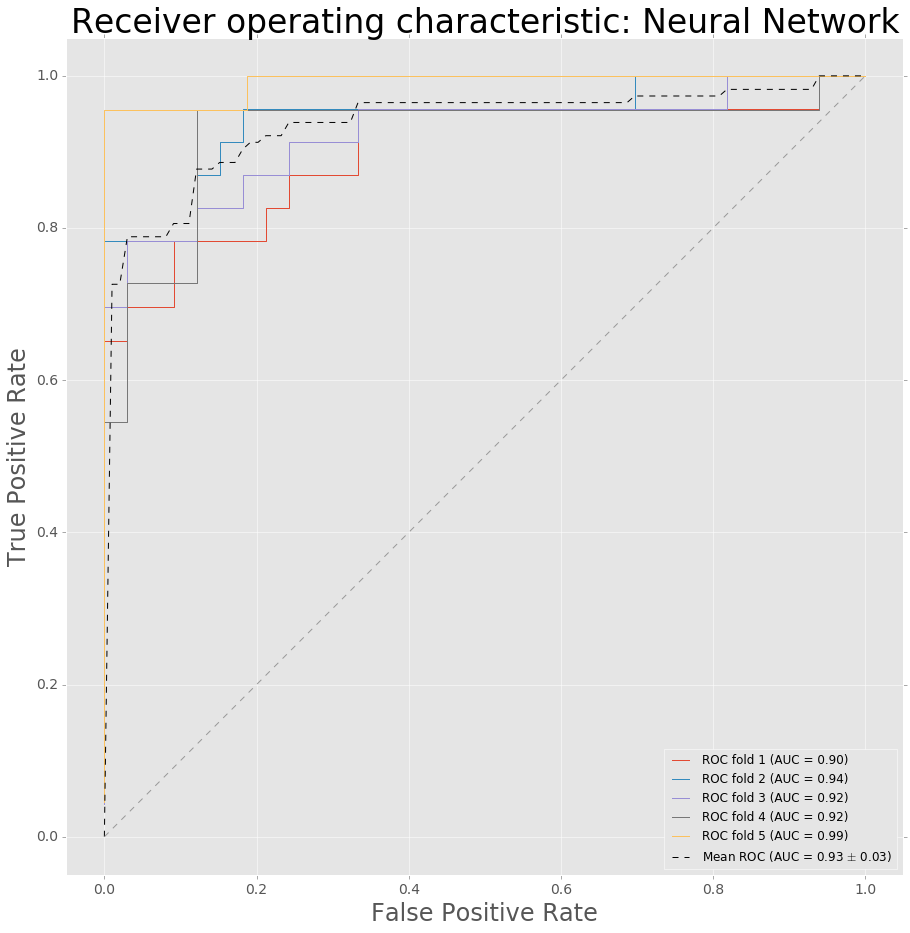

In [36]:
plot_name = 'ROC'
print('plotting :{}'.format(plot_name))
plt.rcParams['figure.figsize'] = (15, 15)
mean_fpr = np.linspace(0, 1, 100)
tprs = []
aucs = []
for i, (fpr, tpr) in enumerate(CV_fpr_tpr):                
    tprs.append(interp(mean_fpr, fpr, tpr))
    roc_auc = auc(fpr, tpr)
    aucs.append(roc_auc)
    plt.plot(fpr, tpr, lw=1, label='ROC fold %d (AUC = %0.2f)' % (i+1, roc_auc))
mean_tpr = np.mean(tprs, axis=0)
mean_tpr[0] = 0.0
mean_tpr[-1] = 1.0
Mean_fpr_tpr[model_choice] = mean_tpr
mean_auc = auc(mean_fpr, mean_tpr)
std_auc = np.std(aucs)
plt.plot(mean_fpr, mean_tpr, 'k--', label=r'Mean ROC (AUC = %0.2f $\pm$ %0.2f)' % (mean_auc, std_auc))
plt.plot([0, 1], [0, 1], '--', color=(0.6, 0.6, 0.6))
plt.xlim([-0.05, 1.05])
plt.xticks(fontsize=14)
plt.ylim([-0.05, 1.05])
plt.yticks(fontsize=14)
plt.xlabel('False Positive Rate', fontsize = 24)
plt.ylabel('True Positive Rate', fontsize = 24)
plt.title('Receiver operating characteristic: {}'.format(model_choice), fontsize = 33)
plt.legend(loc="lower right")
plt.show()

## Convolutional Neural Network

In [37]:
import keras
from keras.models import Sequential,Input,Model,load_model
from keras.layers import Dense, Dropout, Flatten, Activation, BatchNormalization
from keras.layers.convolutional import Conv1D, MaxPooling1D
from keras.layers.normalization import BatchNormalization
from keras.layers.advanced_activations import LeakyReLU
from keras.optimizers import SGD, Adadelta, Adagrad
from keras.callbacks import ModelCheckpoint

Using TensorFlow backend.


In [38]:
X_conv = np.expand_dims(X, axis=2)
y_conv = keras.utils.to_categorical(y, 2)

In [46]:

CV_fpr_tpr = []
CV_fpr_tpr_thrsh = []
CV_CM_test=[]
CV_Acc_test=[]
CV_AUC_test=[]
CM_total = np.array([[0.0,0.0],[0.0,0.0]], np.int64)

model_choice = "CNN"
np.random.seed(100)

batch_size = 128
nb_classes = 2

y_test = []
y_test_pred = []
subject_id = []
for train, test in kf.split(X, y):
    y_test.append(y[test])
    subject_id.extend(np.array(path)[test])
    
    clf = Sequential()
    clf.add(Conv1D(16, 3, padding='same',input_shape=(193, 1)))
    clf.add(Activation('relu'))
    clf.add(BatchNormalization())
    clf.add(Conv1D(32, 3))
    clf.add(Activation('relu'))
    clf.add(BatchNormalization())
    clf.add(MaxPooling1D(pool_size=2))
    clf.add(Dropout(0.25))

    clf.add(Conv1D(64, 3, padding='same'))
    clf.add(Activation('relu'))
    clf.add(BatchNormalization())
    clf.add(Conv1D(128, 3))
    clf.add(Activation('relu'))
    clf.add(BatchNormalization())
    clf.add(MaxPooling1D(pool_size=2))
    clf.add(Dropout(0.3))

    clf.add(Flatten())
    clf.add(Dense(512, activation='relu'))
    clf.add(BatchNormalization())
    clf.add(Dropout(0.4))
    clf.add(Dense(nb_classes))
    clf.add(Activation('softmax'))
    sgd = SGD(lr=0.01, decay=1e-6, momentum=0.9, nesterov=True)
    clf.compile(loss='categorical_crossentropy', optimizer=sgd,metrics=['accuracy'])

    clf.fit(X_conv[train], y_conv[train], batch_size=batch_size, epochs=30, verbose=0, validation_split = 0.2, 
            callbacks=[ModelCheckpoint('cnn.best.model.hdf5',monitor='val_acc',save_best_only=True,mode='auto')])
    print("Finish fold")
    clf.load_weights('cnn.best.model.hdf5')
    
    y_pred_prob = clf.predict(X_conv[test])
    y_pred = y_pred_prob.argmax(axis=-1)
    y_test_pred.extend(y_pred)
    
    CV_Acc_test.append(acc(y[test], y_pred))
    
    fpr, tpr, thresholds = roc_curve(y[test], y_pred_prob[:,1])
    CV_fpr_tpr.append((fpr,tpr))
    CV_fpr_tpr_thrsh.append(thresholds)
    CV_AUC_test.append(roc_auc_score(y[test], y_pred_prob[:,1]))
    
    CM_test = confusion_matrix(y[test],y_pred)
    CM_total = CM_total + CM_test
    CV_CM_test.append(CM_test)

    
All_test_pred[model_choice] = y_test_pred

Finish fold
Finish fold
Finish fold
Finish fold
Finish fold


In [47]:
print('Acc (mean, std_err): {:04.2f}, {:04.2f}'.format(np.mean(CV_Acc_test), np.std(CV_Acc_test)))
print('AUC (mean, std_err): {:04.2f}, {:04.2f}'.format(np.mean(CV_AUC_test), np.std(CV_AUC_test)))
print('Confusion Matrix:', CM_total)

ppv = CM_total[1][1] / (CM_total[0][1] + CM_total[1][1])
npv = CM_total[0][0] / (CM_total[0][0] + CM_total[1][0])
sens = CM_total[1][1] / (CM_total[1][0] + CM_total[1][1])
spec = CM_total[0][0] / (CM_total[0][0] + CM_total[0][1])
print('Sensitivity: {:04.2f}'.format(sens))
print('Specificity: {:04.2f}'.format(spec))
print('PPV: {:04.2f}'.format(ppv))
print('NPV: {:04.2f}'.format(npv))

Acc (mean, std_err): 0.86, 0.04
AUC (mean, std_err): 0.88, 0.06
Confusion Matrix: [[145  19]
 [ 21  92]]
Sensitivity: 0.81
Specificity: 0.88
PPV: 0.83
NPV: 0.87


plotting :Confusion_Matrix


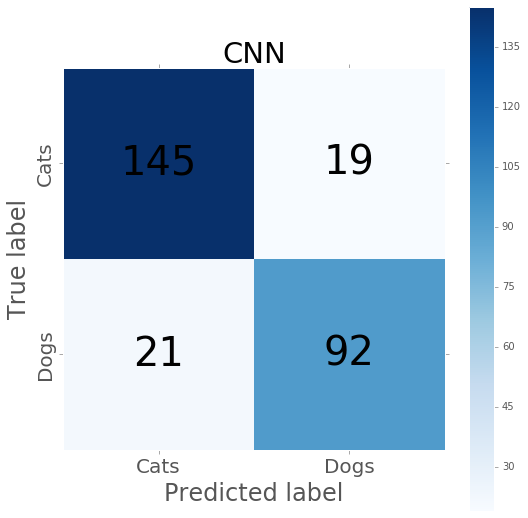

In [48]:
plot_name = 'Confusion_Matrix'
print('plotting :{}'.format(plot_name))
plt.rcParams['figure.figsize'] = (7, 7)
class_labels = ['Cats','Dogs']
plt.imshow(CM_total, interpolation='nearest',cmap=plt.cm.Blues)
plt.title(model_choice, fontsize = 29)
plt.colorbar()
tick_marks = np.arange(len(class_labels))
plt.xticks(tick_marks, class_labels, fontsize = 20)
plt.yticks(tick_marks,class_labels, rotation=90, fontsize = 20)
plt.tight_layout(0)
plt.ylabel('True label', fontsize = 24)
plt.xlabel('Predicted label', fontsize = 24)
plt.grid(0)
for x_lab in range(2):
    for y_lab in range(2):
        plt.text(y_lab, x_lab, CM_total[x_lab, y_lab], horizontalalignment='center',verticalalignment='center',fontsize=40)

plotting :ROC


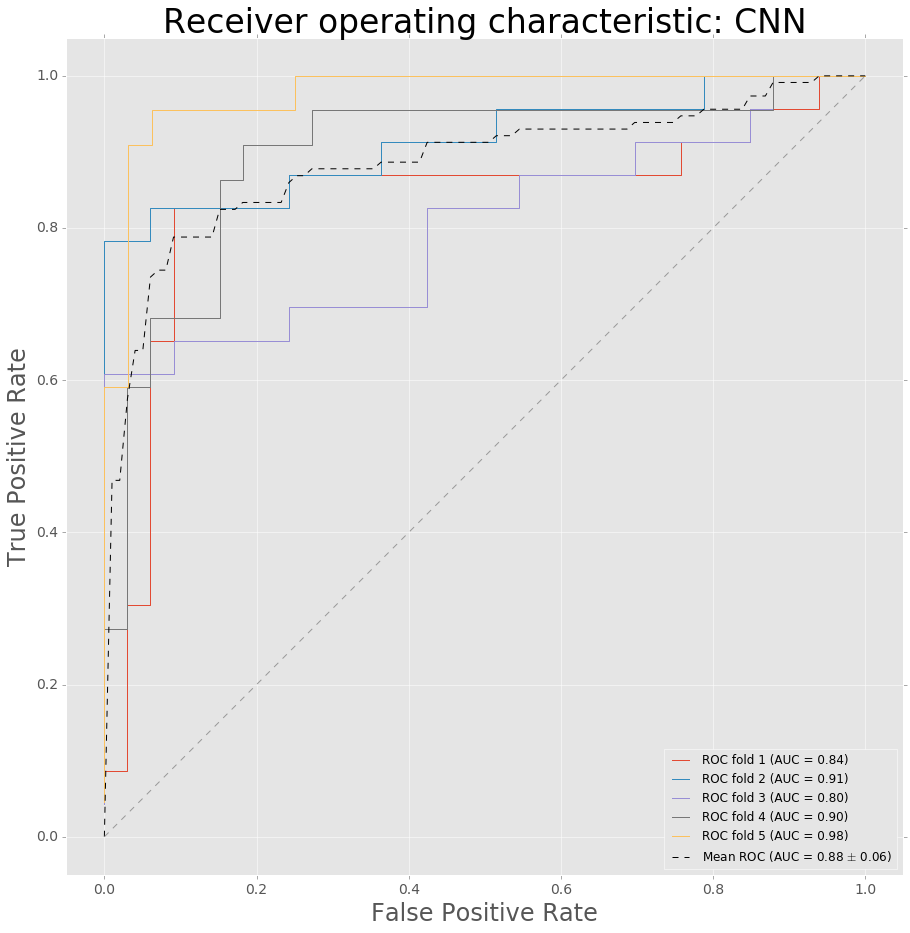

In [49]:
plot_name = 'ROC'
print('plotting :{}'.format(plot_name))
plt.rcParams['figure.figsize'] = (15, 15)
mean_fpr = np.linspace(0, 1, 100)
tprs = []
aucs = []
for i, (fpr, tpr) in enumerate(CV_fpr_tpr):                
    tprs.append(interp(mean_fpr, fpr, tpr))
    roc_auc = auc(fpr, tpr)
    aucs.append(roc_auc)
    plt.plot(fpr, tpr, lw=1, label='ROC fold %d (AUC = %0.2f)' % (i+1, roc_auc))
mean_tpr = np.mean(tprs, axis=0)
mean_tpr[0] = 0.0
mean_tpr[-1] = 1.0
Mean_fpr_tpr[model_choice] = mean_tpr
mean_auc = auc(mean_fpr, mean_tpr)
std_auc = np.std(aucs)
plt.plot(mean_fpr, mean_tpr, 'k--', label=r'Mean ROC (AUC = %0.2f $\pm$ %0.2f)' % (mean_auc, std_auc))
plt.plot([0, 1], [0, 1], '--', color=(0.6, 0.6, 0.6))
plt.xlim([-0.05, 1.05])
plt.xticks(fontsize=14)
plt.ylim([-0.05, 1.05])
plt.yticks(fontsize=14)
plt.xlabel('False Positive Rate', fontsize = 24)
plt.ylabel('True Positive Rate', fontsize = 24)
plt.title('Receiver operating characteristic: {}'.format(model_choice), fontsize = 33)
plt.legend(loc="lower right")
plt.show()

### ROC for all models

plotting :ROC


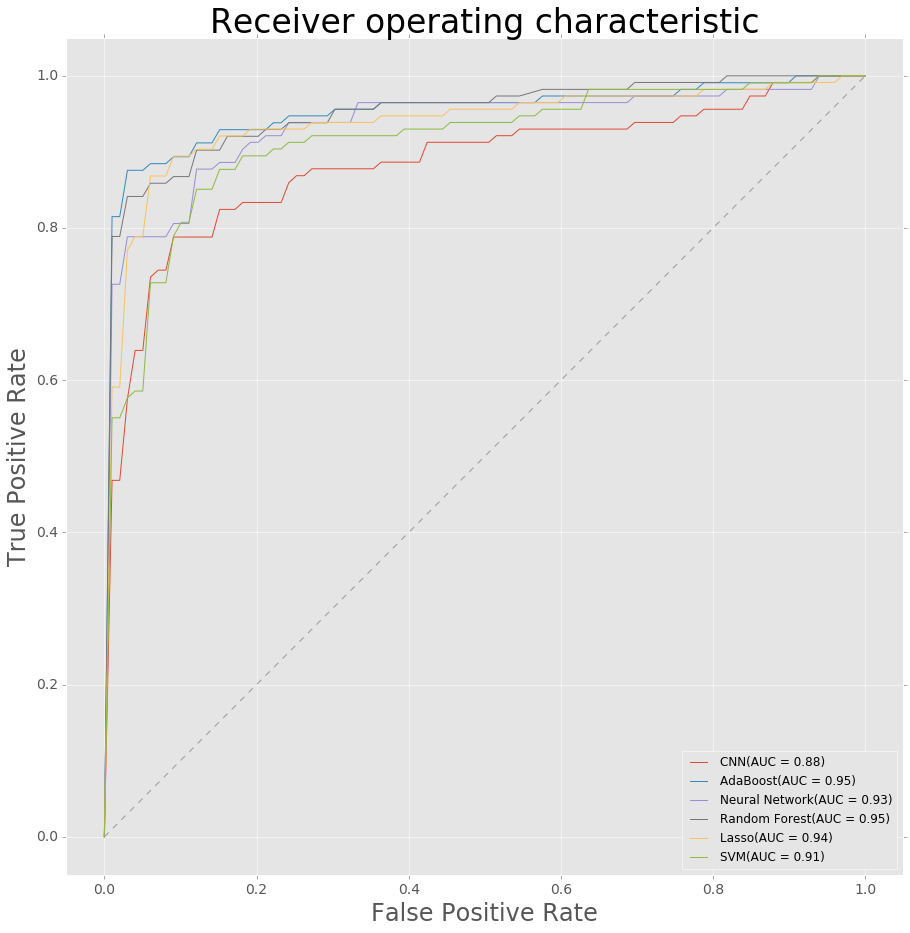

In [50]:
plot_name = 'ROC'
print('plotting :{}'.format(plot_name))
plt.rcParams['figure.figsize'] = (15, 15)

for model, tpr in Mean_fpr_tpr.items(): 
    fpr = np.linspace(0, 1, 100)
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, lw=1, label=model + '(AUC = %0.2f)' % (roc_auc))
    
plt.plot([0, 1], [0, 1], '--', color=(0.6, 0.6, 0.6))
plt.xlim([-0.05, 1.05])
plt.xticks(fontsize=14)
plt.ylim([-0.05, 1.05])
plt.yticks(fontsize=14)
plt.xlabel('False Positive Rate', fontsize = 24)
plt.ylabel('True Positive Rate', fontsize = 24)
plt.title('Receiver operating characteristic', fontsize = 33)
plt.legend(loc="lower right")
plt.show()

In [51]:
y_true = []
for train, test in kf.split(X, y):
    y_true.extend(y[test])
y_true = np.array(y_true)

In [53]:
import statsmodels.stats.contingency_tables as sm

print("Performing Macnemar's test")
model_list = list(All_test_pred.keys())
for i, m1 in enumerate(model_list):
    m1_pred = np.array(All_test_pred[m1])
    m1_acc = y_true == m1_pred
    for j in range(i+1, len(model_list)):
        m2 = model_list[j]
        m2_pred = np.array(All_test_pred[m2])
        m2_acc = y_true == m2_pred
        contingency_table = np.array([[np.sum((m1_acc == 1) & (m2_acc == 1)), np.sum((m1_acc == 1) & (m2_acc == 0))],
                                      [np.sum((m1_acc == 0) & (m2_acc == 1)), np.sum((m1_acc == 0) & (m2_acc == 0))]])
        mcnemar = sm.mcnemar(contingency_table)
        print("{} vs {}: statistics {:04.4f}, pvalue {:04.4f}".format(m1, m2, mcnemar.statistic, mcnemar.pvalue))
        print(contingency_table)
        

Performing Macnemar's test
CNN vs AdaBoost: statistics 9.0000, pvalue 0.0614
[[228   9]
 [ 20  20]]
CNN vs Neural Network: statistics 7.0000, pvalue 0.0192
[[230   7]
 [ 20  20]]
CNN vs Random Forest: statistics 12.0000, pvalue 0.1214
[[225  12]
 [ 22  18]]
CNN vs Lasso: statistics 8.0000, pvalue 0.1516
[[229   8]
 [ 16  24]]
CNN vs SVM: statistics 14.0000, pvalue 1.0000
[[222  15]
 [ 14  26]]
AdaBoost vs Neural Network: statistics 5.0000, pvalue 0.7744
[[243   5]
 [  7  22]]
AdaBoost vs Random Forest: statistics 5.0000, pvalue 1.0000
[[242   6]
 [  5  24]]
AdaBoost vs Lasso: statistics 12.0000, pvalue 0.7011
[[233  15]
 [ 12  17]]
AdaBoost vs SVM: statistics 9.0000, pvalue 0.0428
[[227  21]
 [  9  20]]
Neural Network vs Random Forest: statistics 6.0000, pvalue 0.6072
[[241   9]
 [  6  21]]
Neural Network vs Lasso: statistics 8.0000, pvalue 0.3833
[[237  13]
 [  8  19]]
Neural Network vs SVM: statistics 4.0000, pvalue 0.0043
[[232  18]
 [  4  23]]
Random Forest vs Lasso: statistics 13.